In [23]:
using Pkg
Pkg.add("PyPlot") # adds a plotting package
Pkg.update() # updates all packages
Pkg.add("PyCall")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [24]:
using Random
using PyPlot


In [25]:
Pkg.add("SpecialFunctions")
Pkg.add("Distributions")
using SpecialFunctions

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [26]:
using DelimitedFiles
using Statistics
using StatsBase
using Distributions

In [27]:
Mrough=readdlm("exoplanet-data.txt")
Xrough=Mrough[:,1]
Yrough=Mrough[:,2]
N=findall(z -> isnan(z), Yrough)
X=deleteat!(Xrough, N)
Y=deleteat!(Yrough, N);
DaysPerIndex=(X[end]-X[1])/(length(X))

0.020695756374495795

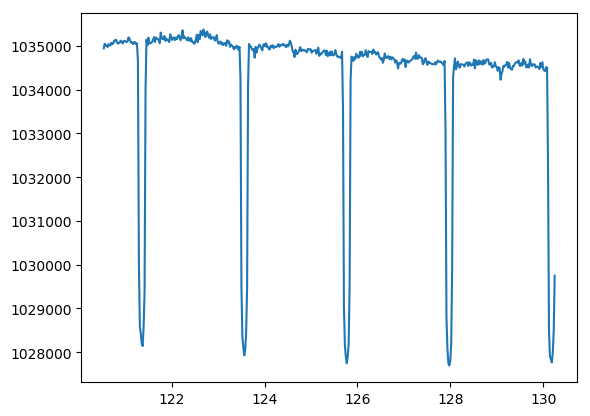

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2ce1e21400>

In [28]:
plt[:plot](X,Y)

In [49]:
#Important Functions
function findlocalmaxima(sig, threshold)
    signal=copy(sig)
    inds = Int[]
    if length(signal)>1
        if signal[1]>signal[2]&&signal[1]>threshold
            push!(inds,1)
        end
        for i=2:length(signal)-1
            if signal[i-1]<signal[i]>signal[i+1]&&signal[i]>threshold
                push!(inds,i)
            end
        end
        if signal[end]>signal[end-1]&& signal[end]>threshold
            push!(inds,length(signal))
        end
    end
    return inds
end

function peaklessAverage(sig, peak, width)
    signal=copy(sig)
    for i in 1:length(peak)
        if peak[i]+width<=length(signal) && peak[i]-width>=1
            range= collect(peak[i]-width:1:peak[i]+width)
        elseif peak[i]+width>length(signal)
            range=collect(peak[i]-width:1:length(signal))
        elseif peak[i]-width<length(signal)
            range=collect(1:1:peak[i+width])
        end
        deleteat!(signal, range)
        peak=peak.-length(range)
    end
    return mean(signal)
end

peaklessAverage (generic function with 1 method)

In [52]:
Mean=mean(Y)
peaks=findlocalmaxima(-Y, -(1031000))
print(peaks)
periods=zeros(length(peaks)-1)
for i in 1:length(periods)
    periods[i]=DaysPerIndex*(peaks[i+1]-peaks[i])
end
NormalMean=peaklessAverage(Y, peaks, 5)

print(mean(periods))

[42, 148, 255, 360, 466]2.1937501756965543

7

# Autoregression

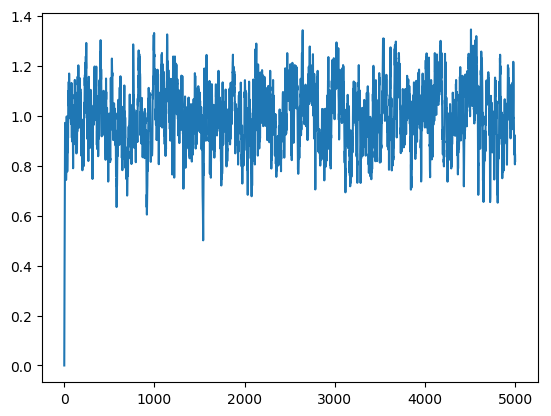

0.015132427064614137

In [14]:
steps=5000
ϕ=0.9
c=0.1
σe=0.05
Xa=zeros(steps)
Xa[1]=0
for i in 2:steps
    Xa[i]=c+ϕ*Xa[i-1]+randn()*σe
end

plt[:plot](Xa)

Xmean=mean(Xa)
Xvar=var(Xa)


In [15]:
function getAutoCovariance(series, max::Int64)
    autoCov=zeros(2*max+1)
    m=mean(series)
    for i in -max:max
        if i<0
            autoCov[i+max+1]=mean((series[1-i:end].-m).*(series[1:end+i].-m))
        end
        if i>=0
            autoCov[i+max+1]=mean((series[1:end-i].-m).*(series[i+1:end].-m))
        end
    end
    return autoCov
end


getAutoCovariance (generic function with 1 method)

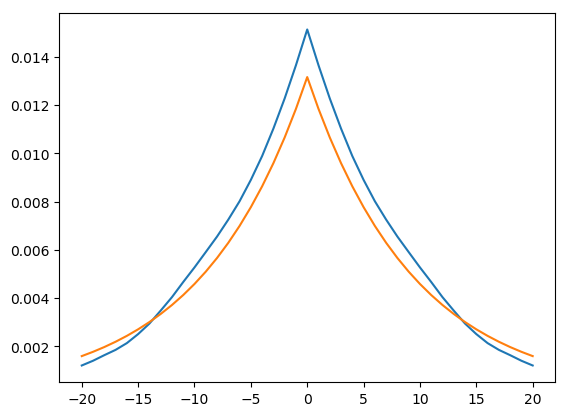

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2ce1fb0358>

In [18]:
maxN=20
autocov=getAutoCovariance(Xa, maxN)
plt[:plot](-maxN:maxN,autocov[1:end])
plt[:plot](-maxN:maxN, σe^2/(1-ϕ^2)*ϕ.^(abs.(-maxN:maxN)))

# 6.1 Power Spectrum of the Ornstein-Uhlenbeck Process

As demonstrated by the proof of the Khinchin-Wiener Theorem the power spectrum of a signal can be approximated by the Fourier Transform of its autocovariance function, if the autocovariance function goes to zero for large intervals. Then the power spectrum can be expressed as

$$S(ω)= \hat{A}(ω).$$
    
As proved in the lectures, the autocovariance function of the Ornstein-Uhlenbeck Process is

$$ A(T)=\langle x(t)x(t+T)\rangle = σ^2 e^{-|T|/τ}.$$

As $A(T)$ goes to zero for large $|T|$ can now easily obtain the Power Spectrum

$$ S(ω)= \hat{A}(ω) = \int_{-\infty}^{\infty} e^{-iωT}A(T)dT=\int_{-\infty}^{\infty} e^{-iωT}σ^2 e^{-|T|/τ}dT, $$

which is a common integral that evaluates to

$$ S(ω)= \frac{σ^2}{ω^2 τ^2 +1}.$$


# 6.2 Correlated Ornstein-Uhlenbeck Processes

In order to derive expressions for the same-time covariance and the cross-covariance of the two processes, we require expressions of the general solutions of these processes, which were derived in class:

$$  x(t) = μ + σ \sqrt{2 τ_x} \int_{-\infty}^{t} \frac{ds}{τ_x} e^{-(t-s)}ξ(s)$$

and

$$  y(t) = μ + σ \sqrt{2 τ_y} \int_{-\infty}^{t} \frac{ds}{τ_y} e^{-(t-s)}ξ(s),$$

where $μ=0$ for the case at hand.

We will go ahead and calculate the cross-variance straight away, as the same-time covariance is just a special case of the cross-covariance for when $T=0$.

For $T>0$ we have

$$\langle x(t)y(t+T) \rangle = 2σ^2 \sqrt{τ_x τ_y} \int_{-\infty}^{t}\frac{ds}{τ_x}\int_{-\infty}^{t+T}\frac{ds'}{τ_y} exp{\left[ -\frac{t-s}{τ_x} - \frac{t+T-s'}{τ_y} \right]} \langle ξ(s)ξ(s') \rangle .$$

Since $\langle ξ(s)ξ(s') \rangle=δ(s-s')$, this double integral simplifies to a single integral with lower bound $-\infty$ and upper bound $t$. The upper bound is *not*  $t+T$, because the variable $s$ never takes any values above $t$, which results in the new integral being zero for any value above $t$. Thus

$$ \langle x(t)y(t+T) \rangle = 2σ^2 \sqrt{τ_x τ_y} \int_{-\infty}^{t}\frac{ds}{τ_x}\int_{-\infty}^{t+T}\frac{ds'}{τ_y} exp{\left[ -\frac{t-s}{τ_x} - \frac{t+T-s'}{τ_y} \right]}δ(s-s')  =  \frac{2 σ^2}{\sqrt{τ_x τ_y}} \int_{-\infty}^{t}  exp{\left[ -\frac{t-s}{τ_x} - \frac{t+T-s}{τ_y} \right] } ds $$

$$\langle x(t)y(t+T) \rangle = \frac{2 σ^2}{\sqrt{τ_x τ_y}} e^{-T/τ_y} \int_{-\infty}^{t}  exp{\left[ -(t-s)\frac{τ_x+ τ_y}{τ_x τ_y} \right] } ds  =  \frac{2 σ^2}{\sqrt{τ_x τ_y}} e^{-T/τ_y} \left[\frac{τ_x τ_y}{τ_x+ τ_y}exp{\left( -(t-s)\frac{τ_x+ τ_y}{τ_x τ_y} \right) } \right] _{-\infty}^{t} $$

Finally this yields

$$ \langle x(t)y(t+T) \rangle = 2 σ^2 \frac{ \sqrt{τ_x τ_y}}{τ_x+ τ_y} e^{-T/τ_y}.$$

We can check that this result is true, by setting $τ_x= τ_y=τ$, yielding the autocovariance function

$$ \langle x(t)x(t+T) \rangle = σ^2 e^{-T/τ} $$

for positive $T$.

The result derived above is only valid for positive $T$, as the boundaries of the integral will change depending on whether or not $T$ is positive. For the negative cross-covariance we write (still assuming $T$ is positive)

$$\langle x(t)y(t-T) \rangle = 2σ^2 \sqrt{τ_x τ_y} \int_{-\infty}^{t}\frac{ds}{τ_x}\int_{-\infty}^{t-T}\frac{ds'}{τ_y} exp{\left[ -\frac{t-s}{τ_x} - \frac{t-T-s'}{τ_y} \right]}δ(s-s') = \frac{2 σ^2}{\sqrt{τ_x τ_y}} \int_{-\infty}^{t-T}  exp{\left[ -\frac{t-s}{τ_x} - \frac{t-T-s}{τ_y} \right] }  $$

The upper limit of the new integral is $t-T$ as that is the largest value that $s$ and $s'$ have in common. Continuing the computation yields

$$\langle x(t)y(t-T) \rangle = \frac{2 σ^2}{\sqrt{τ_x τ_y}}  e^{+T/τ_y} \int_{-\infty}^{t-T}  exp{\left[ -(t-s)\frac{τ_x+ τ_y}{τ_x τ_y} \right] } ds = \frac{2 σ^2}{\sqrt{τ_x τ_y}}e^{+T/τ_y} \int_{-\infty}^{t-T}  exp{\left[ -\frac{t-s}{τ_x} - \frac{t-T-s}{τ_y} \right] } 
$$


$$ = \frac{2 σ^2}{\sqrt{τ_x τ_y}} e^{+T/τ_y} \left[\frac{τ_x τ_y}{τ_x+ τ_y}exp{\left( -(t-s)\frac{τ_x+ τ_y}{τ_x τ_y} \right) } \right] _{-\infty}^{t-T}, $$

which finally yields

$$\langle x(t)y(t-T) \rangle = 2 σ^2 \frac{ \sqrt{τ_x τ_y}}{τ_x+ τ_y} e^{-T/τ_x}  $$ 

This shows that the positive cross-covariance is dependent on $τ_y$ while the negative cross-covariance is dependent on $τ_x$. 

The same-time covariance can now easily be derived from the case when $T=0$, yielding

$$\langle x(t)y(t) \rangle = 2 σ^2\frac{ \sqrt{τ_x τ_y}}{τ_x+ τ_y} $$

In [ ]:
ω σ τ μ ξ δ